# Exploração dados COVID-19 em Portugal

In [1]:
import pandas as pd
df = pd.read_csv("https://raw.githubusercontent.com/jgrocha/covid-pt/master/situacao_epidemiologica.csv")
df.head()

,id,url,data_relatorio,suspeitos,confirmados,nao_confirmados,aguarda_resultados,recuperados,obitos,em_vigilancia,...,obitos_masculino_80_sup,obitos_feminino_0_9,obitos_feminino_10_19,obitos_feminino_20_29,obitos_feminino_30_39,obitos_feminino_40_49,obitos_feminino_50_59,obitos_feminino_60_69,obitos_feminino_70_79,obitos_feminino_80_sup
0,5,https://covid19.min-saude.pt/wp-content/upload...,2020-03-07,224,21,NaN,47.0,NaN,0,412.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,6,https://covid19.min-saude.pt/wp-content/upload...,2020-03-08,281,30,NaN,56.0,NaN,0,447.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,8,https://covid19.min-saude.pt/wp-content/upload...,2020-03-10,375,41,NaN,83.0,NaN,0,667.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,11,https://covid19.min-saude.pt/wp-content/upload...,2020-03-13,1308,112,NaN,172.0,NaN,0,5674.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,12,https://covid19.min-saude.pt/wp-content/upload...,2020-03-14,1704,169,NaN,126.0,1.0,0,5011.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


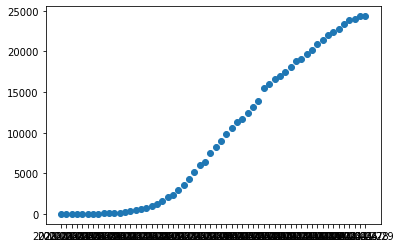

In [2]:
import matplotlib.pyplot as plt

sorted_df = df.sort_values(by=['data_relatorio'])

x = sorted_df.data_relatorio
y = sorted_df.confirmados
plt.scatter(x, y)

In [3]:
import os
import sys
from osgeo import ogr
os.environ['QT_QPA_PLATFORM'] = 'offscreen'
sys.path.insert(0,'/usr/share/qgis/python')
from qgis.core import *
#QgsApplication.setPrefixPath("/usr/local", True) 
from qgis.gui import *
from qgis import processing

from qgis.PyQt.QtGui import QColor, QImage
from qgis.PyQt.QtCore import QSize, QBuffer, QIODevice

qgs = QgsApplication([], False)
qgs.initQgis()
print(QgsApplication.showSettings())

Application state:
QGIS_PREFIX_PATH env var:		
Prefix:		/usr
Plugin Path:		/usr/lib/qgis/plugins
Package Data Path:	/usr/share/qgis
Active Theme Name:	
Active Theme Path:	/usr/share/qgis/resources/themes//icons/
Default Theme Path:	:/images/themes/default/
SVG Search Paths:	/usr/share/qgis/svg/
		/home/diogoesnog/.local/share/profiles/default/svg/
User DB Path:	/usr/share/qgis/resources/qgis.db
Auth DB Path:	/home/diogoesnog/.local/share/profiles/default/qgis-auth.db



In [4]:
covid_gpkg = "covid-pt-2020-04-20.gpkg"
conn = ogr.Open(covid_gpkg)
for i in conn:
    vlayer = QgsVectorLayer("{}|layername={}".format(covid_gpkg, i.GetName()), i.GetName(), "ogr")
    if not vlayer.isValid():
        print("Layer {} failed to load".format(i.GetName()))
    else:
        QgsProject.instance().addMapLayer(vlayer)
        print("Layer {} loaded".format(i.GetName()))


Layer concelho loaded
Layer distrito loaded
Layer raa_central_concelho loaded
Layer raa_central_ilha loaded
Layer raa_ocidental_concelho loaded
Layer raa_ocidental_ilha loaded
Layer raa_oriental_concelho loaded
Layer raa_oriental_ilha loaded
Layer ram_concelho loaded
Layer ram_ilha loaded
Layer layer_styles loaded
Layer confirmados_concelho loaded
Layer confirmados_distrito_ilha loaded
Layer situacao_epidemiologica loaded


In [5]:
concelho = QgsProject.instance().mapLayersByName('concelho')[0]
for c in concelho.getFeatures():
        print("Em {} há {} caso(s) confirmados".format(c["concelho"], c["confirmados_concelho_20/04/2020"]))

Em ÁGUEDA há 42 caso(s) confirmados
Em ALBERGARIA-A-VELHA há 57 caso(s) confirmados
Em ANADIA há 20 caso(s) confirmados
Em AROUCA há 30 caso(s) confirmados
Em AVEIRO há 237 caso(s) confirmados
Em CASTELO DE PAIVA há 8 caso(s) confirmados
Em ESPINHO há 56 caso(s) confirmados
Em ESTARREJA há 56 caso(s) confirmados
Em SANTA MARIA DA FEIRA há 340 caso(s) confirmados
Em ÍLHAVO há 91 caso(s) confirmados
Em MEALHADA há 13 caso(s) confirmados
Em MURTOSA há 8 caso(s) confirmados
Em OLIVEIRA DE AZEMÉIS há 150 caso(s) confirmados
Em OLIVEIRA DO BAIRRO há 18 caso(s) confirmados
Em OVAR há 511 caso(s) confirmados
Em SÃO JOÃO DA MADEIRA há 52 caso(s) confirmados
Em SEVER DO VOUGA há 28 caso(s) confirmados
Em VAGOS há 15 caso(s) confirmados
Em VALE DE CAMBRA há 92 caso(s) confirmados
Em ALJUSTREL há NULL caso(s) confirmados
Em ALMODÔVAR há 3 caso(s) confirmados
Em ALVITO há NULL caso(s) confirmados
Em BARRANCOS há NULL caso(s) confirmados
Em BEJA há 9 caso(s) confirmados
Em CASTRO VERDE há NULL caso(

In [6]:
expr_sem_casos = QgsExpression( " \"confirmados_concelho_20/04/2020\" IS NULL " )
virgens = list(concelho.getFeatures( QgsFeatureRequest( expr_sem_casos ) ))
for c in virgens:
        print("Em {} não há pelos menos 3 casos confirmados".format(c["concelho"]))

Em ALJUSTREL não há pelos menos 3 casos confirmados
Em ALVITO não há pelos menos 3 casos confirmados
Em BARRANCOS não há pelos menos 3 casos confirmados
Em CASTRO VERDE não há pelos menos 3 casos confirmados
Em CUBA não há pelos menos 3 casos confirmados
Em FERREIRA DO ALENTEJO não há pelos menos 3 casos confirmados
Em MÉRTOLA não há pelos menos 3 casos confirmados
Em ODEMIRA não há pelos menos 3 casos confirmados
Em OURIQUE não há pelos menos 3 casos confirmados
Em VIDIGUEIRA não há pelos menos 3 casos confirmados
Em FREIXO DE ESPADA À CINTA não há pelos menos 3 casos confirmados
Em MOGADOURO não há pelos menos 3 casos confirmados
Em BELMONTE não há pelos menos 3 casos confirmados
Em FUNDÃO não há pelos menos 3 casos confirmados
Em IDANHA-A-NOVA não há pelos menos 3 casos confirmados
Em OLEIROS não há pelos menos 3 casos confirmados
Em PENAMACOR não há pelos menos 3 casos confirmados
Em PROENÇA-A-NOVA não há pelos menos 3 casos confirmados
Em VILA DE REI não há pelos menos 3 casos con

In [7]:
xt = concelho.extent()
# print(xt)
width  = 400
height = int(width*xt.height()/xt.width())
print("Gerar mapa com {} por {}".format(width, height))

options = QgsMapSettings()
options.setLayers([concelho])
options.setBackgroundColor(QColor(255, 255, 255))
options.setOutputSize(QSize(width, height))
options.setExtent(xt)
           
render = QgsMapRendererParallelJob(options)
render.start()
render.waitForFinished()

image = render.renderedImage()


Gerar mapa com 400 por 819


In [8]:
from IPython.display import Image

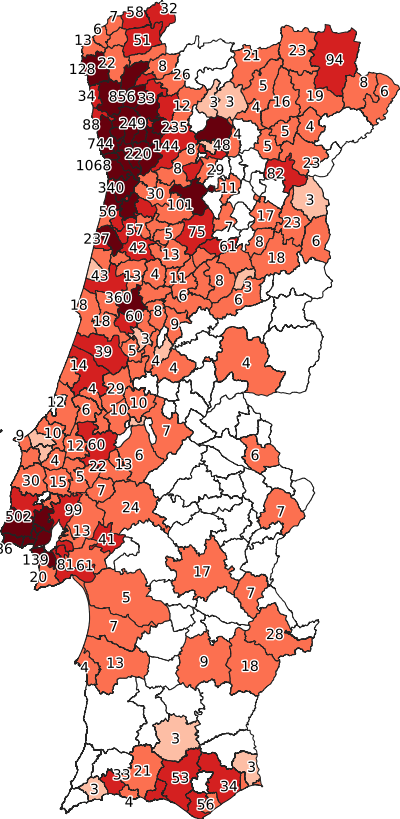

In [9]:
imgbuf= QBuffer()
imgbuf.open( QIODevice.ReadWrite )
image.save( imgbuf,"PNG" )
Image( imgbuf.data() )